   # Convolutional Neural Network

Here we will put together a CNN using Keras. 

### Imports for building models

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


### Imports for data pre-processing and training 

In [2]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
#https://github.com/jrosebr1/imutils
from keras.utils import to_categorical
from keras.models import load_model
from imutils import paths
import imutils
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os

## LeNet architecture

To start we will use a simple image classifier architecture called LetNet.

Layers:

Input -> Convolution_1 -> Pooling_1 -> Convolution_2 -> Pooling_2 -> Fully_Connected_Hidden_Layer -> Output_Softmax

## Setting up LeNet CNN

In [3]:
#Create a class for the model
class LeNet:
    @staticmethod
    def build(width, height, depth, classes):
        #Create instance of model
        model = Sequential()
        inputShape = (height, width, depth)
        #Add layers
        
        #First convolutional layer w/ 20 convolutional filters which are 5x5 pixels
        #Padding set to same so input size into the convolution is the same as output
        #Activation can be set in convolutiuonal layer or added separately
        model.add(Conv2D(filters=20, kernel_size=5, padding='same',
                         input_shape=inputShape, activation='relu'))
        #model.add(Activation('relu'))
        #Calculate the max values of pixels in a window size of 2x2 pixels
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        #2nd covolutional layer
        model.add(Conv2D(filters=50, kernel_size=5, padding='same',
                        activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        #Flatten layer serves as a connecter between convolution and densely connected layers
        #Flattens into a single vector
        model.add(Flatten())
        #Dense layer contains 500 fully connected nodes
        model.add(Dense(500, activation='relu'))
        #Can add activation layer separately
        #model.add(Activation('relu'))
        #Output will be number of classes, softmax will yield probability of each class
        model.add(Dense(classes, activation='softmax'))
        
        return model

In [4]:
#Tuning layer parameters
class LeNet2:
    @staticmethod
    def build(width, height, depth, classes):
        #Create instance of model
        model = Sequential()
        inputShape = (height, width, depth)
        #increase filters to 30
        model.add(Conv2D(filters=30, kernel_size=5, padding='same',
                         input_shape=inputShape, activation='relu'))
        #increase pool size to 3
        model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
        #increase filters to 75
        model.add(Conv2D(filters=75, kernel_size=5, padding='same',
                        activation='relu'))
        #increase pool size to 3
        model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
        model.add(Flatten())
        model.add(Dense(500, activation='relu'))
        model.add(Dense(classes, activation='softmax'))
        
        return model

## AlexNet Architecture 

Input -> Convolution_1 -> Pooling_1 -> Convolution_2 -> Pooling_2 -> Convolution_3 -> Convolution_4 ->

Pooling_3 -> Fully_Connected_Hidden_Layer_1 -> Dropout_Layer_1 -> Fully_Connected_Hidden_Layer_2 ->

Dropout_Layer_2 -> Output_Softmax

## AlexNet CNN

In [5]:
class AlexNet:
    #optimizer to use should be 'sgd'
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        #input shape is 227x227x3
        inputShape = (height, width, depth)
        model.add(Conv2D(filters=96, kernel_size=11, strides=4,
                         input_shape=inputShape, activation='relu'))
        model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
        model.add(Conv2D(filters=256, kernel_size=5, strides=1,
                         padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
        model.add(Conv2D(filters=384, kernel_size=3, strides=1,
                         padding='same', activation='relu'))
        model.add(Conv2D(filters=256, kernel_size=3, strides=1,
                         padding='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
        model.add(Flatten())
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(classes, activation='softmax'))
        
        return model

## Image Pre-processing

In [6]:
def pre_process(width, height, path):
    """
    Resize and rescale images stored in image folder.
    
    Return pre-processed data and labels for the classes based
    on sub-directories in the image folder
    """
    #containers for pre-processed image data and class labels
    data = []
    labels = []

    #images directory contains 3 sub-directories: 'poison_ivy', 'poison_oak', 'poison_sumac'
    #randomly get image paths and shuffle them
    # current path 'C:\\Users\\jltsa\\Desktop\\Project_2\\images'
    image_paths = sorted(list(paths.list_images(path)))
    random.seed(42)
    random.shuffle(image_paths)

    #preprocess images to width x height pixels as required for LeNet
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (width, height))
        image = img_to_array(image)
        data.append(image)
    
        #Extract class labels
        label = image_path.split(os.path.sep)[-2]
        if label == 'poison_ivy':
            label = 0
        elif label == 'poison_oak':
            label = 1
        else:
            label = 2
        labels.append(label)
       
    #Scal pixel intensities from 0 to 1
    data = np.array(data, dtype='float') / 255.0
    labels = np.array(labels)
    
    return data, labels

## Training CNN

In [7]:
#Initialize global training variables

EPOCHS = 25
#Learning rate
LR = 1e-3
#Batch Size
BS = 20

### Training and Test Data for LeNet

In [174]:
#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)


In [175]:
#One hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [13]:
#To increase the amount of training data, build an image generator using data augmentation
aug_gen = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                            height_shift_range=0.1, shear_range=0.2,
                            zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

In [177]:
model = LeNet.build(width=28, height=28, depth=3, classes=3)
opt = Adam(lr=LR, decay=LR / EPOCHS)

model.compile(loss='categorical_crossentropy', optimizer=opt,
             metrics=['accuracy'])

In [178]:
lnet = model.fit_generator(aug_gen.flow(X_train, y_train, batch_size=BS),
                   validation_data=(X_test, y_test), steps_per_epoch=len(X_train // BS),
                   epochs=3, verbose=1)

Epoch 1/3
538/538 [==============================] - 15s 29ms/step - loss: 0.9130 - acc: 0.5469 - val_loss: 0.9192 - val_acc: 0.5889
Epoch 2/3
538/538 [==============================] - 8s 14ms/step - loss: 0.6958 - acc: 0.6801 - val_loss: 1.1744 - val_acc: 0.5944
Epoch 3/3
538/538 [==============================] - 8s 14ms/step - loss: 0.4400 - acc: 0.8151 - val_loss: 1.2616 - val_acc: 0.6167


In [167]:
#Initialize model
model = LeNet2.build(width=28, height=28, depth=3, classes=3)
opt = SGD(lr=LR, decay=LR / EPOCHS)

#if model has 2 classes use loss='binary_crossentropy'
model.compile(loss='categorical_crossentropy', optimizer=opt,
             metrics=['accuracy'])

In [130]:
#train model
lnet_2 = model.fit_generator(aug_gen.flow(X_train, y_train, batch_size=BS),
                   validation_data=(X_test, y_test), steps_per_epoch=len(X_train // BS),
                   epochs=EPOCHS, verbose=1)

Epoch 1/25
538/538 [==============================] - 8s 16ms/step - loss: 0.9325 - acc: 0.5349 - val_loss: 0.9084 - val_acc: 0.5556
Epoch 2/25
538/538 [==============================] - 7s 13ms/step - loss: 0.7173 - acc: 0.6708 - val_loss: 1.1252 - val_acc: 0.5444
Epoch 3/25
538/538 [==============================] - ETA: 0s - loss: 0.4786 - acc: 0.793 - 7s 14ms/step - loss: 0.4773 - acc: 0.7937 - val_loss: 1.4747 - val_acc: 0.5722
Epoch 4/25
538/538 [==============================] - 7s 14ms/step - loss: 0.2968 - acc: 0.8837 - val_loss: 1.3226 - val_acc: 0.6722
Epoch 5/25
538/538 [==============================] - 7s 13ms/step - loss: 0.1806 - acc: 0.9335 - val_loss: 1.7712 - val_acc: 0.6167
Epoch 6/25
538/538 [==============================] - 7s 13ms/step - loss: 0.1426 - acc: 0.9498 - val_loss: 1.7708 - val_acc: 0.6167
Epoch 7/25
538/538 [==============================] - 8s 14ms/step - loss: 0.0955 - acc: 0.9666 - val_loss: 1.9737 - val_acc: 0.6000
Epoch 8/25
538/538 [===========

In [131]:
#Save model
#model.save('models\\model_lenet_2.h5')

In [40]:
#Load model
#model = load_model('poison_plant_model.h5')

### Training and Test Data for AlexNet

In [8]:
data_alexnet, labels_alexnet = pre_process(227, 227, 'C:\\Users\\jltsa\\Desktop\\Project_2\\images')

In [9]:
#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_alexnet, labels_alexnet, test_size=0.25, random_state=42)

In [10]:
#One hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
#Initialize model
model_alex = AlexNet.build(width=227, height=227, depth=3, classes=3)
opt_alex = Adam(lr=LR, decay=LR / EPOCHS)

#if model has 2 classes use loss='binary_crossentropy'
model_alex.compile(loss='categorical_crossentropy', optimizer=opt_alex,
             metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
alex_1 = model_alex.fit_generator(aug_gen.flow(X_train, y_train, batch_size=BS),
                   validation_data=(X_test, y_test), steps_per_epoch=len(X_train // BS),
                   epochs=EPOCHS, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
543/543 [==============================] - 131s 242ms/step - loss: 1.0276 - acc: 0.4648 - val_loss: 0.9900 - val_acc: 0.4530
Epoch 2/25
543/543 [==============================] - 124s 229ms/step - loss: 1.0093 - acc: 0.4640 - val_loss: 0.9926 - val_acc: 0.4530
Epoch 3/25
543/543 [==============================] - 120s 220ms/step - loss: 1.0061 - acc: 0.4652 - val_loss: 0.9898 - val_acc: 0.4530
Epoch 4/25
543/543 [==============================] - 133s 245ms/step - loss: 1.0050 - acc: 0.4651 - val_loss: 0.9922 - val_acc: 0.4530
Epoch 5/25
543/543 [==============================] - 133s 246ms/step - loss: 1.0052 - acc: 0.4661 - val_loss: 0.9892 - val_acc: 0.4530
Epoch 6/25
543/543 [==============================] - 135s 248ms/step - loss: 1.0109 - acc: 0.4593 - val_loss: 0.9887 - val_acc: 0.4530
Epoch 7/25
543/543 [==============================] - 126s 232ms/step - loss: 1.0053 - acc: 0.4661 - val_loss: 0.9912 - val_acc: 0.4530


In [19]:
model_alex.save('models\\model_alex_1.h5')

In [185]:
model_alex.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 13, 13, 256)       884992    
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 6, 6, 256)         0         
__________

## Evaluate Models

In [16]:
def plot_acc_loss(epochs, model, title=None, save=False, path=None, save_as=None):
    """
    plot the accuracy and loss of the train and test data
    save plot optional
    """
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0,epochs), model.history['loss'], label='Train_loss')
    plt.plot(np.arange(0,epochs), model.history['val_loss'], label='Val_loss')
    plt.plot(np.arange(0,epochs), model.history['acc'], label='Train_acc')
    plt.plot(np.arange(0,epochs), model.history['val_acc'], label='Val_acc')
    plt.title('Training Loss and Accuracy' + ' ' + str(title))
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Acc')
    plt.legend(loc='upper left')
    
    if save == True:
        plt.savefig(str(path)+'\\' + str(save_as) + '.png')

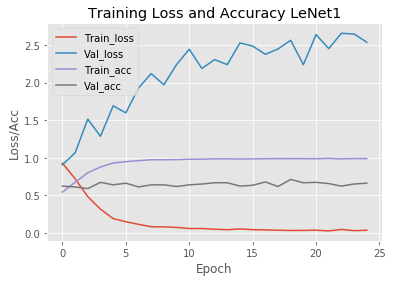

In [156]:
plot_acc_loss(EPOCHS, lnet, save=True, title='LeNet1', path='plots', save_as='lnet_1acc')

Validation Loss keeps increasing.  The model is over fitting.  Maybe need to add drop out layer? get better pictures, more pics of sumac.

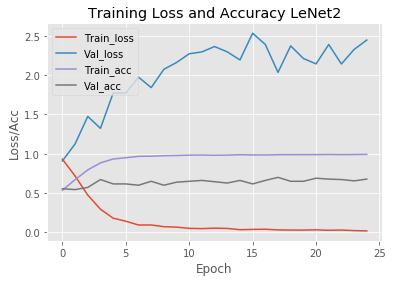

In [157]:
plot_acc_loss(EPOCHS, lnet_2, title = 'LeNet2', save=True, path='plots', save_as='lnet_2acc')

In [134]:
model2 = load_model('models\\model_lenet_1.h5')
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 20)        1520      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 7, 7, 50)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2450)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 500)               1225500   
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 1503      
Total para

In [133]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 30)        2280      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 30)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 13, 13, 75)        56325     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 6, 6, 75)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2700)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 500)               1350500   
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 1503      
Total para

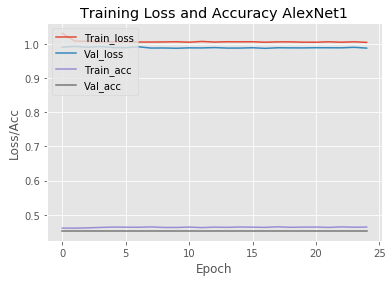

In [17]:
plot_acc_loss(EPOCHS, alex_1, title = 'AlexNet1', save=True, path='plots', save_as='alexnet_1acc')

AlexNet doe not seem to be learning

Take it back a step, do binary classification is or is not.

Thesis - Design an app with a suite of idenetification features for identifying poisonous plants or mushrooms